# DIM0782 - Machine Learning (DIMAp/UFRN/2024.1)

## Preprocessing the data

### Transforming non-structured data to structured data

This is textual data, so the first step is to turn it into structured data by applying a transformer. I'm going to work mostly with BERT here.

First, I'm going to define the imports block.

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb

Now reading the sentiments dataset:

In [2]:
sentiments_df = pd.read_csv("datasets/twitter_sentiment_base_original.csv", usecols=["text", "label"])
sentiments_df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


###  Creating a Shorter Dataset (Optional Step)
-- -------------------------

This might be helpful in case your base is originally too big to be processed on a reasonable time for this exercise. Running this block would still allow you to run the subsequent blocks of code with no issues. You can totally skip this step as well in case you have the computing power to process the original dataset.

In [3]:
sample_size, random_state = 4000, 42
sampled_data = []

for i in range(6): ## Since we have 6 sentimens, labeled from 0 to 5
    sampled_data.append(sentiments_df[sentiments_df['label'] == i].sample(n=sample_size, random_state=random_state))

sentiments_df = pd.concat(sampled_data)
sentiments_df

,text,label
133243,ive learned to surround myself with women who ...,0
88501,i already feel crappy because of this and you ...,0
131379,i feel like i have lost mourned and moved past...,0
148369,i could write a whole lot more about why im fe...,0
134438,i always seem to feel inadequate,0
...,...,...
44216,i feel a strange sadness because the downhill ...,5
370216,i feel absolutely amazing when i have a conver...,5
118400,im not going to repeat every word written in t...,5
347704,i feel impressed to extend this to all,5


-- ----------
### End of Optional Block

Now I'm going to utilize a BERT tokenizer to transform the text data that I have.

In [4]:
## Loading the pretrained model and tokenizer
tokenizer = (ppb.DistilBertTokenizer).from_pretrained('distilbert-base-uncased')
model = (ppb.DistilBertModel).from_pretrained('distilbert-base-uncased')

## Tokenizing w/ BERT
sentiments_tokenized = sentiments_df["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

The code above outputs the tokenized data with rows of different sizes, since each sentence has a different length. We now need to apply a process called padding in order to make all of the sentences with equal size. We will also need an attention mask, which will tell BERT which rows he should consider the data or not.

In [5]:
## Generating a new dataframe with the tokenized data appended with their associated labels
biggest_sentence_length = 0
for i in sentiments_tokenized.values:
    if len(i) > biggest_sentence_length:
        biggest_sentence_length = len(i)

## Getting the values padded and the attention mask
sentiments_tokenized_padded = np.array([i + [0]*(biggest_sentence_length-len(i)) for i in sentiments_tokenized.values])
attention_mask = np.where(sentiments_tokenized_padded != 0, 1, 0)

Now we're finally going to process those input IDs that we generated on the steps above and we will generate the actual BERT embeddings. Given the size of the dataset, I ran multiple tests and realized that memory would be an issue. I need to split this into batches and work from there.

In [7]:
input_ids = torch.tensor(sentiments_tokenized_padded)
attention_mask = torch.tensor(attention_mask)
batch_size = 4000      # Change it as it is necessary 
all_hidden_states = [] # BERT generates what we call hidden states

def batch_generator(input_ids, attention_mask, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_mask[i:i+batch_size]

## Processes the input over batches through the help of a generator
with torch.no_grad():
    for batch_ids, batch_mask in batch_generator(input_ids, attention_mask, batch_size):
        outputs = model(batch_ids, attention_mask=batch_mask)
        all_hidden_states.append(outputs.last_hidden_state)

## Concatenates all batch results
last_hidden_states = torch.cat(all_hidden_states, dim=0)

#### Optional (minor)
-- --------------

Getting all of that on a file to ensure this data gets saved. Can be adapted to retrieve a previously saved tensor as well, so that you don't have to run the embeddings algorithm on the future.

In [8]:
## Saves or loads tensor to or from a file
# torch.save(last_hidden_states, 'tensor.pt')
last_hidden_states = torch.load('datasets/tensor.pt')

-- ------------
#### End of Minor Optional Block

Now we can extract the features:

In [10]:
sentiments_features = last_hidden_states[:,0,:].numpy()
labels = sentiments_df['label']

Additionally, I may want to generate a CSV file containing the structured data. This can be achieved by running:

In [12]:
sentiments_df_embedded = pd.DataFrame({'features': sentiments_features.tolist(), 'label': labels})
sentiments_df_embedded.to_csv('datasets/twitter_sentiment_base_tokenized.csv')

## Reduction of Instances (WIP)

As part of this work, it is required to reduce instances on my dataset.

The goal here is to collect 14972 random instances from each of the 6 classes the sentiments dataset has, and create a new base with this balanced collection.

In [18]:
## Variables for the sampling conditions
sample_size, random_state = 14972, 42
sampled_data = []

for i in range(6): ## Since we have 6 sentimens, labeled from 0 to 5
    sampled_data.append(sentiments_tokenized_df[sentiments_tokenized_df['label'] == i].sample(n=sample_size, random_state=random_state))

sampled_sentiments_df = pd.concat(sampled_data)
sampled_sentiments_df

,text,label
133243,"[101, 4921, 2063, 4342, 2000, 15161, 2870, 200...",0
88501,"[101, 1045, 2525, 2514, 10231, 7685, 2138, 199...",0
131379,"[101, 1045, 2514, 2066, 1045, 2031, 2439, 9587...",0
148369,"[101, 1045, 2071, 4339, 1037, 2878, 2843, 2062...",0
134438,"[101, 1045, 2467, 4025, 2000, 2514, 14710, 102...",0
...,...,...
142937,"[101, 1045, 4384, 2026, 6181, 2318, 3110, 1037...",5
373641,"[101, 1045, 2514, 2023, 2428, 7622, 2068, 1998...",5
148816,"[101, 10047, 2183, 2000, 3745, 2055, 2026, 430...",5
23199,"[101, 1045, 4342, 2008, 2065, 1045, 5454, 1062...",5


Now I'm just going to generate a CSV file with this new dataset.

In [19]:
sampled_sentiments_df.to_csv('datasets/twitter_sentiments_base_sampled.csv')

## Attribute selection (w/ Decision Trees)

Decision trees are quite useful for the purpose of doing attribute (or feature) selection because they inherently perform feature selection by splitting nodes based on the most informative features. By using a decision tree, we can identify which attributes (or features) contribute most to predicting the output, making it a practical approach for reducing dimensionality and improving model interpretability.

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

sentiments_embeddings_train, sentiments_embeddings_test, sentiments_labels_train, sentiments_labels_test = train_test_split(sentiments_features, labels, test_size=0.2, random_state=42)

# Initialize the classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model
decision_tree.fit(sentiments_embeddings_train, sentiments_labels_train)

# Get feature importances
importances = decision_tree.feature_importances_

# Now we sort the importances on descending order and select the top X features - (X: originally 50)
indices = np.argsort(importances)[::-1]
top_features = indices[:50]

# Finally, we select only the top features that were applied
sentiments_embeddings_train_reduced = sentiments_embeddings_train[:, top_features]
sentiments_embeddings_test_reduced = sentiments_embeddings_test[:, top_features]

Now let us visualize the feature importances from our algorithm:

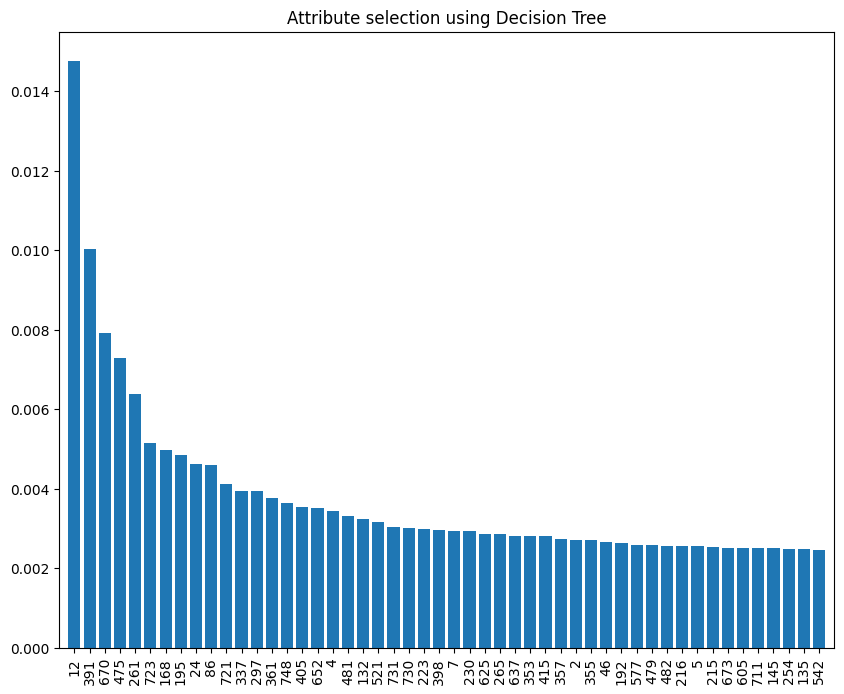

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.title("Attribute selection using Decision Tree")
plt.bar(range(sentiments_embeddings_train_reduced.shape[1]), importances[top_features], align='center')
plt.xticks(range(sentiments_embeddings_train_reduced.shape[1]), top_features, rotation=90)
plt.xlim([-1, sentiments_embeddings_train_reduced.shape[1]])

plt.show()

## Principal Component Analysis (PCA)

Running Principal Component Analysis (PCA) is a powerful method to reduce the dimensionality of our data while retaining as much variability as possible. 

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
sentiments_features_scaled = scaler.fit_transform(sentiments_features)

# Choose the number of components (example: reduce dimensions to keep 95% of the variance)
pca = PCA(n_components=0.95)
sentiments_pca = pca.fit_transform(sentiments_features_scaled)

print(f"Number of components kept: {pca.n_components_}")

Number of components kept: 214


Now, let's examine the explained variance of the PCA. This will tell us how much information (variability) was retained.

In [33]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total variance explained: {sum(explained_variance)}")

Explained variance by each component: [0.13098411 0.09063568 0.05532153 0.05026966 0.03718181 0.0335627
 0.0309852  0.02734337 0.0227272  0.02120668 0.01880902 0.01750765
 0.01609287 0.01548563 0.01466154 0.01341947 0.01170103 0.0106961
 0.00984342 0.00928938 0.00894261 0.00857401 0.00804609 0.00794713
 0.00754434 0.00692301 0.00656436 0.00629978 0.00601705 0.00585967
 0.00556609 0.0052062  0.00501069 0.00494067 0.00479707 0.0044747
 0.00426741 0.00422726 0.00414841 0.00405941 0.00389931 0.00388706
 0.00369942 0.00356525 0.00352549 0.0033838  0.00334331 0.00321038
 0.00312165 0.00301219 0.00290797 0.00276007 0.00272287 0.00267909
 0.00256318 0.00250167 0.00243577 0.00240358 0.00231875 0.00229849
 0.00227383 0.00217715 0.00214474 0.00213408 0.00209029 0.0020382
 0.00202275 0.00193709 0.00189465 0.00186346 0.0018465  0.00180737
 0.00179504 0.00171924 0.00168555 0.00164337 0.00163096 0.00159486
 0.00155878 0.00151573 0.00150573 0.0014916  0.00145182 0.00144282
 0.00142747 0.00140939 0.001

Let us now finally visualize the transformed data.

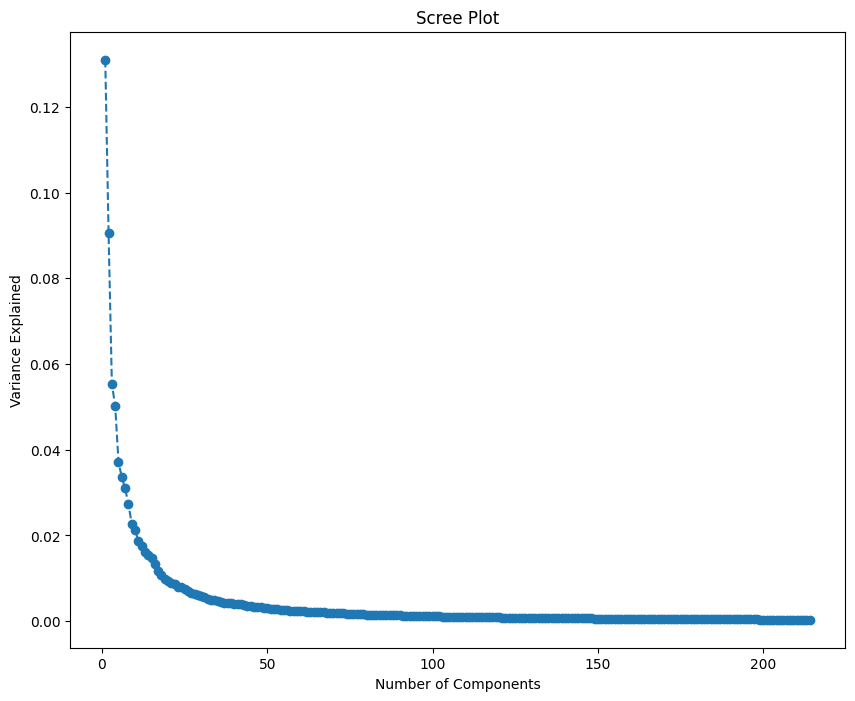

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(range(1, 215), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()

The scree plot generated is a graphical representation of the variance explained by each principal component the analysis.

The x-axis represents the number of principal components. In the plot, it ranges from 1 to over 200.
The y-axis represents the variance explained by each principal component. It shows the proportion of the dataset’s total variance.
Elbow Method: Typically, the goal of a scree plot is to identify the 'elbow' of the graph, which indicates the point at which the variance explained by each additional component drops off and becomes minimal. This point is considered a good cut-off for reducing the number of components because beyond this point, you're getting diminishing returns on explained variance.

In our plot, there is a steep drop after the first few components, then the decline slows significantly. This suggests that the first few components capture a substantial amount of the information (variance) in the dataset. After this initial steep drop, the plot levels off around the 40-component mark, indicating that each additional component contributes less and less.

It’s worth noting that the first component explains significantly more variance than the subsequent ones. In practical terms, this could mean that there is one dominant feature or pattern in your data that accounts for most of the variance, with each additional feature contributing less to explaining the dataset.

Based on this plot, we might consider retaining only the components before the curve starts to flatten if you aim to reduce dimensionality while retaining most of the information.

That's why I'm going to run the PCA algorithm again, but changing the n parameter.

In [43]:
pca_round_two = PCA(n_components=0.75)
sentiments_pca = pca_round_two.fit_transform(sentiments_features_scaled)

print(f"Number of components kept: {pca_round_two.n_components_}")

Number of components kept: 39


Now let's generate this scree plot again:

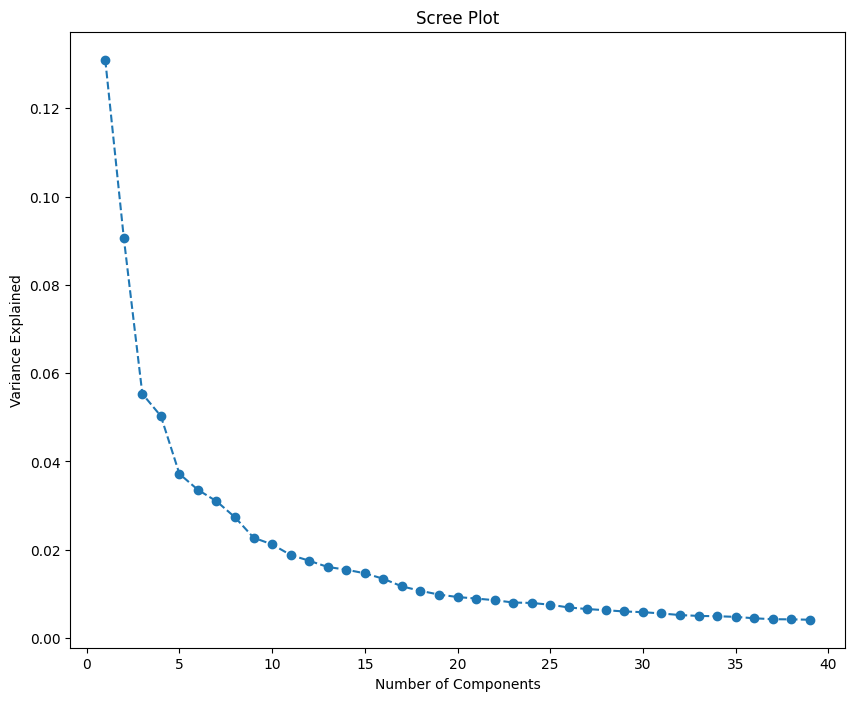

In [44]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 40), pca_round_two.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()